## Este notebook consiste no treinamento da arquitetura Resnet18 pré-treinada disponível no PyTorch
### Para facilitar utilizaremos a biblioteca FastAi, que de forma prática combina as melhores técnicas e arquiteturas que são estado da arte atualmente na área de deep learning hoje de forma intuitiva e simples para uso

Primeiramente, importamos todas as dependências necessárias.

In [1]:
# Dependências ML
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

# Funções úteis para o TCC
from tcc_utils.tcc_training_utils import *

Setamos o dispositivo que rodaremos as equações matriciais de tensores.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda', index=0)
    print("GPU available. Training on {}.".format(torch.cuda.get_device_name()))
else:
    device = default_device()
    print("GPU not available. Training on CPU.")

GPU available. Training on NVIDIA GeForce RTX 2070.


Aqui filtramos alguns warnings do fastai relacionados ao carregamento do otimizador do modelo. É apenas um bug do repositório oficial que já possui PR para arrumar. Enquanto isso esse comando previne a informação de aparecer nas células.

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# FastAi

No fastai, para que você encapsule tudo o que é necessário, são necessários `DataLoaders`, entidades que, no fastai, cuidam de capturar as imagens, redimensioná-las, normalizá-las, separá-las em porcentagem de treinamento e teste, controlar o tamanho do lote de imagens, etc. O Fastai nos fornece uma função como essa específica para diretórios contendo imagens (`ImageDataLoaders`), só é necessário fornecer os hiperparâmetros corretos. No caso atual, utilizaremos 20% do dataset para teste e dos 80% restantes, realizaremos uma validação cruzada, mantendo 80% como treinamento e 20% como teste.
- `TEST_PCT`: Tamanho do set de teste.
- `SIZE`: Tamanho das imagens que serão enviadas para o modelo.
- `BS`: Tamanho do batch

In [4]:
root = './Kaggle Faces Dataset'
PATH = Path(root)

### Obs: Como definir o tamanho das imagens?

A melhor forma de se definir o tamanho das imagens é encontrar o tamanho que melhor minimiza o tempo de computação e a perda de informação. Se, por exemplo, a maior imagem no conjunto de dados tem dimensão 700x700 pixels e todas as outras possuem dimensões 100x100, não faz sentido redimensionar todas para 700x700 pixels e ter que arcar com talvez alguns dias de processamento por época. O melhor a fazer é uma pequena análise dos tamanhos das imagens disponíveis.

Como o redimensionamento necessariamente tornará a imagem quadrada, é possível analisar a raíz quadrada dos valores resultantes da multiplicação da largura e da altura. Como a multiplicação da altura pela largura resulta na quantidade de pixels da imagem, obter a raíz quadrada dos valores resulta nas dimensões quadradas de largura e altura que produzem aquela quantidade de pixels.

In [8]:
paths_to_imgs = PATH.rglob("*.jpg") # paths_to_images é um generator que, dentro de um loop, devolve um caminho de cada vez
quantidade_imagens = 1164203
imgs_sizes_data = []

for path in tqdm(paths_to_imgs, total=quantidade_imagens):
    img = Image.open(path)
    width, height = img.size
    imgs_sizes_data.append(width*height)

  0%|          | 0/1164203 [00:00<?, ?it/s]

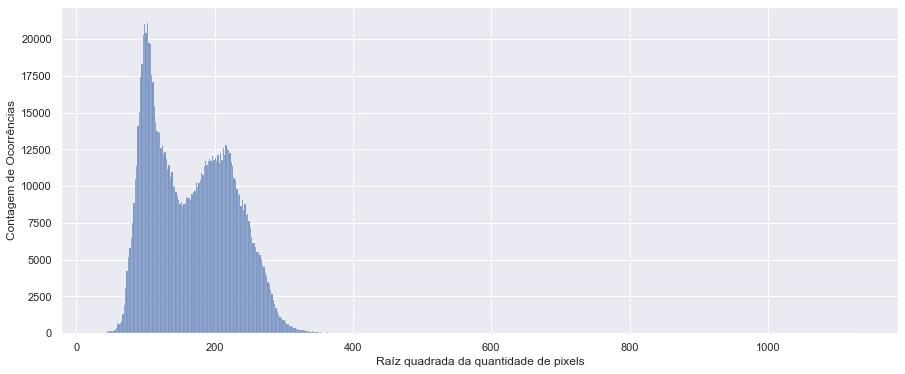

In [23]:
imgs_sizes_data = np.array(imgs_sizes_data)

plt.figure(figsize=(15,6))
sns.histplot(np.sqrt(imgs_sizes_data))
plt.ylabel("Contagem de Ocorrências")
plt.xlabel("Raíz quadrada da quantidade de pixels")
plt.show()

O gráfico indica que a maioria gigantesca das imagens possui a quantidade de pixels abaixo do que as dimensões quadradas 300x300 pixels são capazes de representar. Como as redes pré-treinadas foram treinadas com o tamanho 224x224 pixels, esse parece ser um tamanho interessante para se trabalhar sem perder muita qualidade.

In [5]:
#TEST_PCT=0.2   # 20% do dataset será para o TESTE. Os TREINAMENTOS e a VALIDAÇÕES serão separados por Cross Validation
SIZE=224 # Tamanho padrão das imagens onde as redes pré-treinadas foram treinadas, importante manter consistente
BS=352  # 352 é o limite que a minha GPU RTX 2070 aguenta de imagens sendo passadas durante o treinamento (8GB de memória) e permanece funcionando de forma estável para outras aplicações

Criamos abaixo o `ImageDataLoaders`. Como o conjunto de dados é bem grande, pode demorar um pouco.

In [ ]:
all_data = ImageDataLoaders.from_folder(path=PATH, # Indicamos aqui o caminho que contém as 2 pastas FAKE e REAL
                                        train='train', # Indicamos aqui o nome da pasta que é de treinamento. Observe que como nosso dataset não possui ainda a divisão, deixamos padrão
                                        valid='test', # O mesmo vale para a parte de teste
                                        # valid_pct=TEST_PCT, # Não é necessário indicar a porcentagem de teste na separação principal pois isso já foi realizado por pasta anteriormente
                                        seed=42, # Fornecemos um seed para que a divisão seja sempre a mesma, não importa a execução
                                        bs=BS, # Fornecemos o tamanho do lote de imagens
                                        item_tfms=Resize(SIZE), # Indicamos que queremos redimensionar os itens individuais para o tamanho indicado (224x224 no caso)
                                        batch_tfms=Normalize.from_stats(*imagenet_stats), # Indicamos que queremos normalizar as imagens com os mesmos status de quando foram treinadas 
                                        device=device, # Indicamos que queremos que todos os tensores aqui presentes rodem na GPU, se disponível
                                        num_workers=0 # Esse argumento é necessário para funcionar no windows
                                       )

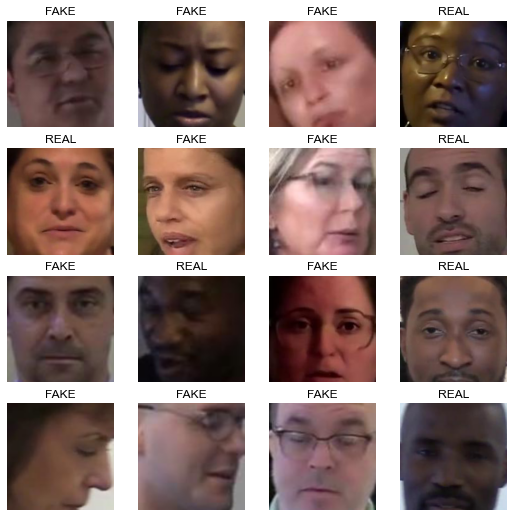

In [10]:
all_data.show_batch(max_n=16, figsize=(9,9))

- `data.vocab`: Quais de fato são as classes do meu dataset.
- `data.c`: Quantas classes diferentes tem no meu dataset.
- `len(data.train/test_ds)`: Qual o tamanho total do meu set de treinamento / validação.

In [44]:
list(all_data.vocab), all_data.c, len(all_data.train_ds), len(all_data.valid_ds)

(['FAKE', 'REAL'], 2, 952940, 211263)

## Validação Cruzada

Pegamos os 80% dos dados que foram previamente separados para treinamento e validação e utilizamos um loop para obter o caminho e a label de cada imagem. Com isso, podemos criar um `DataFrame` onde descrevemos os `80%` do treino e utilizamos para criar a validação cruzada.

Esse dataframe terá como coluna de treinamento `X` o caminho em disco para a respectiva imagem e terá na coluna `y` as respectivas labels "REAL" ou "FAKE" de cada imagem. Não precisamos carregá-lo mais do que necessário após criado uma vez.

In [6]:
path_to_save = './Validações Cruzadas/CompleteDataset.csv'
path_to_save = Path(path_to_save)

if not path_to_save.exists(): # Se o arquivo não existe, o cria
    data_df = []
    tamanho = len(all_data.train_ds.items)
    for i, item in enumerate(all_data.train_ds.items):
        label = item.as_posix().split('/')[2]
        name = item.name
        data_df.append([str(PATH.joinpath("train", label, name)), label])

    data_df = pd.DataFrame(data_df, columns=['x', 'y'])
    data_df.to_csv(path_to_save, index=False)
    
else:
    data_df = pd.read_csv(path_to_save)
    
data_df

x  \
0        Kaggle Faces Dataset\train\FAKE\dfdc_train_part_0 abhggqdift.mp4 1 .jpg   
1       Kaggle Faces Dataset\train\FAKE\dfdc_train_part_0 abhggqdift.mp4 10 .jpg   
2       Kaggle Faces Dataset\train\FAKE\dfdc_train_part_0 abhggqdift.mp4 11 .jpg   
3        Kaggle Faces Dataset\train\FAKE\dfdc_train_part_0 abhggqdift.mp4 2 .jpg   
4        Kaggle Faces Dataset\train\FAKE\dfdc_train_part_0 abhggqdift.mp4 3 .jpg   
...                                                                          ...   
952935   Kaggle Faces Dataset\train\REAL\dfdc_train_part_9 zyizxcfaru.mp4 5 .jpg   
952936   Kaggle Faces Dataset\train\REAL\dfdc_train_part_9 zyizxcfaru.mp4 6 .jpg   
952937   Kaggle Faces Dataset\train\REAL\dfdc_train_part_9 zyizxcfaru.mp4 7 .jpg   
952938   Kaggle Faces Dataset\train\REAL\dfdc_train_part_9 zyizxcfaru.mp4 8 .jpg   
952939   Kaggle Faces Dataset\train\REAL\dfdc_train_part_9 zyizxcfaru.mp4 9 .jpg   

           y  
0       FAKE  
1       FAKE  
2       FAKE  
3       FAKE  
4       FAKE  
...      ...  
952935  REAL  
952936  REAL  
952937  REAL  
952938  REAL  
952939  REAL  

[952940 rows x 2 columns]

O `StratifiedKFold` do sklearn é uma variação do `KFold` regular, porém aqui ele preserva a mesma porcentagem de amostras para cada classe. Dessa forma vamos garantir que todos os folds mantenham uma divisão igualitária das classes (importante pois a classe `REAL` está em minoria e em uma separação poderia ficar completamente de fora).

- `VALID_PCT`: Trata-se da porcentagem que gostaria de se obter no Fold de **validação** do Cross Validation.
- `N_SPLITS`: Quantos folds deve-se ter para obter porcentagem `VALID_PCT` para validação. Essa parte é calculada automaticamente.

<img src="./Imagens/kf.PNG" width="800" height="1000"/>

Criaremos uma lista `data_cv` em que cada elemento conterá um `DataBlock`, que basicamente é uma pipeline para processar, nesse caso, um `DataFrame` de entrada. Os índices de separação virão da validação cruzada. Teremos ao final uma lista contendo 5 DataBlocks específicos de cada etapa da Validação Cruzada.

O `random_state` vai garantir que não importa quando o programa seja executado, a divisão será sempre a mesma.

In [7]:
VALID_PCT = 0.2
N_SPLITS = int(1/VALID_PCT) # n_splits = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# data_cv aqui será nossa lista dos respectivos folds para o cross validation
data_cv = []

for train_idxs, val_idxs in skf.split(data_df['x'], data_df['y']):
    data_cv.append(DataBlock(blocks=(ImageBlock, CategoryBlock),    # Criamos uma lista de imagens a partir de um dataframe.
                             item_tfms=Resize(SIZE),   # Garantimos que o tamanho recuperado para todas as imagens seja de 224px
                             batch_tfms=Normalize.from_stats(*imagenet_stats), # Garantimos que as imagens estejam normalizadas como as utilizadas para treinar a rede anteriormente.
                             splitter=IndexSplitter(val_idxs),   # Dividimos em treinamento e validação pelos índices do cross_validation utilizando FuncSplitter
                             get_x=ColReader(0),   # Cols aqui pode ser uma string com o índice da coluna ou um inteiro indicando o caminho para a imagem, no caso, coluna 0.
                             get_y=ColReader(1)))   # Cols aqui pode ser uma string com o índice da coluna ou um inteiro indicando a classe da imagem, no caso, coluna 1.


In [8]:
def print_dl_info(dl):
    unique_train = np.unique(dl.train_ds.items.y, return_counts=True)
    unique_valid = np.unique(dl.valid_ds.items.y, return_counts=True)
    print(f"DataLoader {split + 1}:\n \
       Classes: {list(dl.vocab)}\n \
       Quantidade de classes: {dl.c}\n \
       Porcentagem dos sets de treinamento e validação: {len(dl.train_ds) / (len(dl.train_ds) + len(dl.valid_ds))*100:.1f}% | {len(dl.valid_ds) / (len(dl.train_ds) + len(dl.valid_ds))*100:.1f}%\n \
       Quantidade de classes FAKE (treinamento): {unique_train[1][0]:,} ({unique_train[1][0] / unique_train[1].sum() * 100:.2f}%)\n \
       Quantidade de Classes REAL (treinamento): {unique_train[1][1]:,} ({unique_train[1][1] / unique_train[1].sum() * 100:.2f}%)\n \
       Quantidade de classes FAKE (validação): {unique_valid[1][0]:,} ({unique_valid[1][0] / unique_valid[1].sum() * 100:.2f}%)\n \
       Quantidade de Classes REAL (validação): {unique_valid[1][1]:,} ({unique_valid[1][1] / unique_valid[1].sum() * 100:.2f}%)")
    print("-"*70)

Criamos oficialmente o primeiro grupo `DataLoaders` para o split 0.

In [9]:
split = 0

# É necessário indicar `num_workers=0` se estiver em um sistema operacional Windows pois o Pytorch multiprocessing não funciona no Windows
fold_dataloader = data_cv[split].dataloaders(data_df, bs=BS, device=device, num_workers=0) 

print_dl_info(fold_dataloader)

DataLoader 1:
        Classes: ['FAKE', 'REAL']
        Quantidade de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 630,392 (82.69%)
        Quantidade de Classes REAL (treinamento): 131,960 (17.31%)
        Quantidade de classes FAKE (validação): 157,598 (82.69%)
        Quantidade de Classes REAL (validação): 32,990 (17.31%)
----------------------------------------------------------------------


A separação occoreu como esperado e as proporções de cada classe foram mantidas.

### Métricas para o treinamento
Quais métricas utilizar para garantir que nosso modelo esteja indo bem?

#### *Matthews Correlation Coefficient*
Antes de tudo, é necessário perceber que nosso dataset contém aproximadamente 5 vezes mais classes "FAKE" do que "REAL". Um modelo que no final apenas chute que toda e qualquer imagem é "FAKE" irá garantir uma acurácia em torno de 83%, o que a princípio pode parecer bom, mas na realidade não apresentará vantagem nenhuma em utilizá-lo. Logo, sabemos que a acurácia não é interessante de ser monitorada sozinha por si só e que o baseline mínimo para ela é de 83%. Para isso, podemos fazer uso da métrica Matthews Correlation Coefficient.

Fonte: https://en.wikipedia.org/wiki/Matthews_correlation_coefficient -> O interessante é que é explicado também o motivo de essa ser uma métrica mais vantajosa do que o F1-score.

A métrica é definida como:

$$MCC=\frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

onde:
- TP = True Positive
- TN = True Negative
- FP = False Positive
- FN = False Negative

O valor retornado sempre estará na faixa de `-1` até `+1`, onde:
- `+1`: Representa uma predição perfeita.
- `0`: Representa um chute nada mais que aleatório.
- `-1`: Representa uma discordância total entre as predições e as observações.

Logo, monitoramos nosso métrica `mcc` e tentamos maximizar seu valor.

#### *AUC ROC Curve*
`AUC` significa ***Area Under the Curve***. `ROC Curve` significa ***Receiver Operating Characteristic Curve***. A ROC Curve é uma plotagem gráfica que ilustra a habilidade diagnóstica de um classificador binário quando sua margem de discriminação é variada. 

No eixo `X` temos a `TPR` ou ***True Positive Rate***.

No eixo `Y` temos a `FPR` ou ***False Positive Rate***.

Fonte: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

A métrica `TPR` é definida como:

$$TPR=\frac{TP}{TP+FN}$$

O valor retornado por `TPR` sempre estará na faixa de `0` até `1`, onde:
- `1`: Dentre todos of rostos que são `FAKE`, o modelo previu corretamente todos como `FAKE`.
- `0`: Dentre todos of rostos que são `FAKE`, o modelo previu incorretamente todos como `REAL`.

A interpretação para o `TPR` é da seguinte forma: "Dentre todos os rostos falsos, quantos o meu modelo de fato classificou como falsos?"

Buscamos sempre maximizar a `TPR`.

---

A métrica `FPR` é definida como:

$$FPR=\frac{FP}{FP+TN}$$

O valor retornado por `FPR` sempre estará na faixa de `0` até `1`, onde:
- `1`: Dentre todos of rostos que são `REAL`, o modelo previu incorretamente todos como `FAKE`.
- `0`: Dentre todos of rostos que são `REAL`, o modelo previu corretamente todos como `REAL`.

A interpretação para o `FPR` é da seguinte forma: "Dentre todos os rostos reais, quantos o meu modelo classificou incorretamente como falsos?"

Buscamos sempre minimizar a `FPR`.

---

`AUC` nada mais é que uma maneira de comparar diferentes `ROC Curves`. A `AUC` é calculada obtendo-se a área sob a curva `ROC`. Abaixo um exemplo típico de curvas ROC e AUC.

<img src="./Imagens/roc_auc.PNG" width="800" height="1000"/>

Dessa forma queremos que o nosso `auc_roc_score` seja o maior possível.

# Criando a Rede: Resnet18

Vamos começar com uma resnet18. Usarei essa arquitetura como base para detalhar o treinamento. As próximas arquiteturas seguirão o mesmo procedimento de forma mais direta. Elas estarão em outros notebooks neste mesmo diretório.

Criamos nosso `learner` que é de fato a rede neural. Colocaremos as métricas de acurácia, `mcc` e `auroc`. A arquitetura dela será a `resnet18` pré treinada no ImageNet.

Utilizaremos também o callback `.to_fp16()` no nosso `learner` e isso permitirá nosso modelo treinar em `MixedPrecision`, permitindo tirar vantagem dos **Tensor Cores** das placas mais recentes da NVIDIA. A utilização de `MixedPrecision` traz consigo diversas vantegens, a principal delas sendo aumento de velocidade no treinamento sem perda de acurácia comparada ao treinamento em full precision, além de ocupar menos memória na GPU. Documentação do próprio FastAi explicando em detalhes: https://docs.fast.ai/callback.fp16

Vamos adicionar dois callbacsk no nosso learner: um basicamente irá parar o treinamento caso a métrica `mcc` não melhores durante duas épocas por um fator mínimo `min_delta=0.01` e o outro é a classe que torna possível o cálculo da AUC como métrica.

Os dados que nosso `learner` recebe serão os diferentes splits do Cross Validation.

In [7]:
mcc = MatthewsCorrCoef() # Matthews Correlation Coeficient
auroc = RocAucBinary() # AUC Score

Lembrando que `fold_dataloader` já foi separado como nosso primeiro split para treinamento da validação cruzada.

In [11]:
learn = cnn_learner(dls=fold_dataloader, 
                    arch=resnet18, 
                    metrics=[accuracy, mcc, auroc]
                   ).to_fp16()

### Dataset desbalanceado

Como observamos anteriormente, nosso dataset está desbalanceado pela alta presença de DeepFakes no dataset de treinamento. Existem várias formas de lidar com isso. Uma delas é simplesmente apagar grande parte das imagens FAKE, mas se fizermos isso nós podemos perder informação valiosa. Outra forma de lidar com isso é garantir que a rede seja penalizada com mais força caso erre uma classe `REAL`. Para fazer isso, recorremos à nossa função de custo, a `CrossEntropyLoss`. Podemos mudar essa função no nosso `learner` passando pesos para as classes, que por padrão possuem peso `1.0`. Para calcular o peso das classes, uma forma comum feita é `weight_label_i = max(nr_samples_per_label) / nr_samples_label_i`. Ou seja, pegamos o número de amostras da classe mais populosa e dividimos pelo número de amostras da classe `i`. Observamos que para a classe mais populosa do dataset o peso continuará sendo `1.0`, mas no caso da mais em falta o peso irá ser maior de uma forma proporcional. Por questões empíricas de estabilidade, vamos dividir o resultado para o peso da classe `REAL` por 2.

In [12]:
# Pegamos a quantidade de amostras por classe
unique_train = np.unique(fold_dataloader.train_ds.items.y, return_counts=True)[1]

# Fake Weight
fake_weight = unique_train.max() / unique_train[0]
# Real Weight
real_weight = unique_train.max() / unique_train[1] / np.sqrt(3)

weight = torch.FloatTensor([fake_weight, real_weight]).to(device) # Temos de passar esse tensor para a placa de vídeo uma vez que o modelo está nela
weight

tensor([1.0000, 2.7581], device='cuda:0')

Feita a correta alteração podemos agora corrigir os pesos da função de custo do nosso learner.

In [13]:
learn.loss_func = CrossEntropyLossFlat(weight=weight)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Perfeito.

# Fold 1
## Treinamento

Utilizamos a função `lr_find()` para encontrar uma região otimizada para o nosso `learning_rate`. Basicamente o que buscamos é uma região com elevado declive e que no momento seja um learning rate razoavelmente alto. Essa região nos indica a fração que devemos utilizar para o `learning_rate`. Essa técnica para encontrar um learning rate, chamada *learning rate range test*, vem do trabalho de *Leslie n. Smith*: 

#### *Cyclical Learning Rates for Training Neural Networks*: https://arxiv.org/pdf/1506.01186.pdf

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.013182567432522774)

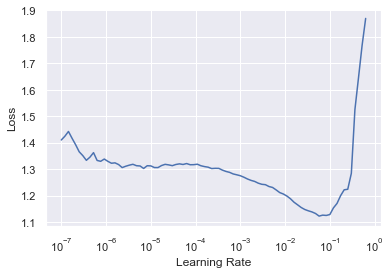

In [13]:
learn.lr_find()

Obtivemos uma região de declive entre $10^{-4}$ e $10^{-1}$. Vamos treinar utilizando $10^{-2}$ (um valor um pouco maior que combina com a política do Learning Rate Scheduler).

Treinamos a rede então por um determinado número de épocas utilizando a política do Scheduler chamada One Cycle, de *Leslie N. Smith*:

#### *Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates*: https://arxiv.org/pdf/1708.07120.pdf

Aqui estarei treinando por 10 épocas (não necessariamente serão treinadas as 10). Para minha placa de vídeo **RTX 2070** espera-se em torno de 1 hora por época.
Também adicionaremos alguns callbacks: um irá salvar o modelo cuja época teve o melhor resultado para `mcc`, evitando assim um possível overfitting por treinamento excessivo; outro irá parar o treinamento caso a métrica não melhore, de forma a economizar recursos computacionais; ao último apenas plota um gráfico do custo ao longo do tempo de treinamento.

Better model found at epoch 0 with matthews_corrcoef value: 0.6089347709828594.


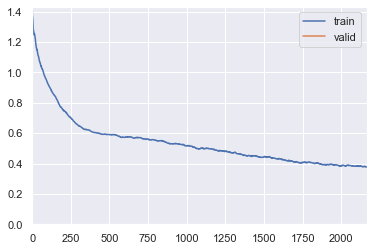

Better model found at epoch 0 with matthews_corrcoef value: 0.7899067179945869.


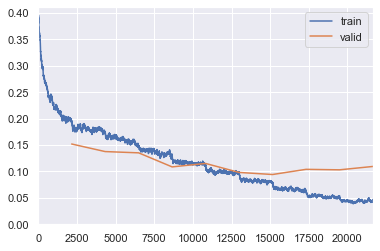

Better model found at epoch 1 with matthews_corrcoef value: 0.8107039177254557.
Better model found at epoch 3 with matthews_corrcoef value: 0.8476618890955913.
Better model found at epoch 5 with matthews_corrcoef value: 0.8645955495281441.
Better model found at epoch 6 with matthews_corrcoef value: 0.8729894360034502.
Better model found at epoch 8 with matthews_corrcoef value: 0.8792617334600477.
Better model found at epoch 9 with matthews_corrcoef value: 0.8806232319437073.


In [14]:
learn.fine_tune(10,
                base_lr=1e-2, 
                cbs=[SaveModelCallback(monitor='matthews_corrcoef', comp=np.greater, fname='resnet18_best_mcc_fold_1'), # Salva o modelo de melhor mcc
                     EarlyStoppingCallback(monitor='matthews_corrcoef', comp=np.greater, min_delta=0.005, patience=2), # Para o treinamento caso o mcc não tenha melhorado no mínimo 0.005 em 2 épocas
                     ShowGraphCallback()]) # Mostra o gráfico do custo

### Interpretação

Vamos criar um interpretador para a CNN treinada que será responsável por algumas funções úteis de interpretação. Porém, antes, iremos adicionar um método que permite a plotagem das imagens com os maiores custos. Esse método é implementado na biblioteca porém do jeito que está exige que todas as imagens sejam carregadas em memória, o que muitas vezes não é viável e não faz sentido para a interpretação de algumas poucas imagens que é o meu objetivo. Para outras funções da biblioteca, acaba por fazer sentido.

In [17]:
def plot_top_losses_without_input(self, k, learn, largest=True, **kwargs):
    from IPython.display import clear_output
    losses, idx = self.top_losses(k, largest)
    self.inputs = TensorImage([])
    for pilImage in [self.dl.dataset[ind.item()][0] for ind in idx]: # Devolvendo uma PIL Image
        dl = learn.dls.test_dl([pilImage], rm_type_tfms=None, num_workers=0)
        inp, preds, _, dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
        self.inputs = torch.cat((inp, self.inputs), dim=0)
        clear_output()
    self.inputs = (TensorImage(self.inputs),)
    temp = idx
    idx = TensorBase(range(k))
    if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
    if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
    else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
    idx = temp # Retornamos os valores de idx para que a função busque as predições de forma correta
    b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
    x,y,its = self.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
    x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
        
Interpretation.plot_top_losses_without_input = plot_top_losses_without_input

Criamos então o interpretador.

In [16]:
path_to_results = "./Preds/preds_resnet18_fold_1.pt"
path_to_results = Path(path_to_results)
if path_to_results.exists():
    preds_data = torch.load(path_to_results)
else:
    preds_data = learn.get_preds(with_decoded=True, with_loss=True) # Obtemos as predições do modelo para o set de validação
    torch.save(preds_data, path_to_results) # Salvamos para uso posterior

preds_data_dict = {"inputs": None, "preds": preds_data[0], "targs": preds_data[1], "decoded": preds_data[2], "losses": preds_data[3]}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_data_dict)

Criamos uma matriz de confusão para checar os resultados.

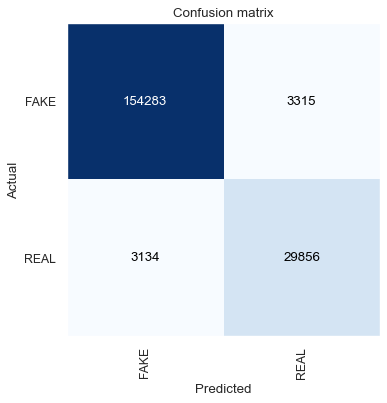

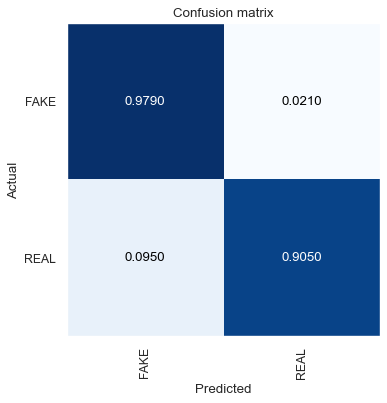

In [17]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

Podemos então utilizar o método definido anteriormente para plotar os rostos que a rede ficou mais confusa. Isto é: rostos que a rede errou a classificação correta e por uma ampla margem, estando bastante certa de que era a classe oposta.

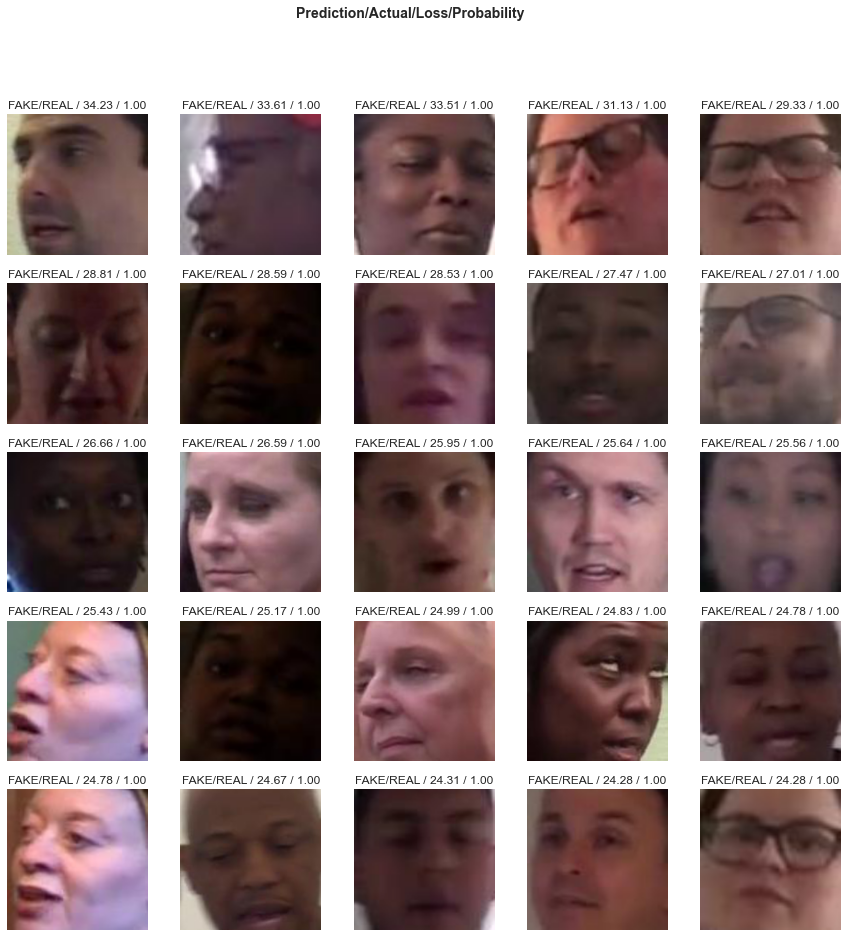

In [18]:
interp.plot_top_losses_without_input(learn=learn, k=25)

Em todos os casos de maior confusão, a rede errou principalmente a classe `REAL`, classificando-a como `FAKE`. Isso é um bom sinal, uma vez que é interessante nesta aplicação que a rede se mantenha conservadora. 

Não queremos que Deepfakes passem, mesmo que seja as custas de algumas predições erradas. Como sabemos que a rede errou também o contrário (classes `FAKE` julgadas como `REAL`), podemos concluir, pela visualização acima, que as errou com baixo valor de custo, ou seja, ela não estava certa de que de fato era um rosto `FAKE`, mas por uma pequena margem decidiu que era `REAL`. Com isso, um poderoso filtro pode ser o nível de certeza da rede, deixando aprovar um rosto como `REAL` apenas se tiver extrema certeza disso.

### Curva ROC e AUC

Para gerarmos a curva ROC, basta passarmos as predições para a função `plot_ROC()`.

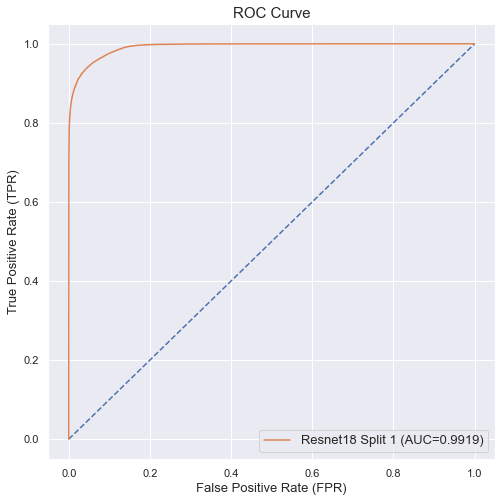

0.9919234228237594

In [19]:
auc_score, _ = plot_ROC(preds=preds_data, labels=[f"Split {split+1}"], model_name='Resnet18')
auc_score

Observamos que a curva apresenta um comportamento excelente, com um valor muito próximo de 1.

# Fold 2
## Treinamento

Para todos os `Folds` de `2` a `5`, os procedimentos serão os mesmos realizados no `Fold` `1`.

In [10]:
split = 1

# É necessário indicar `num_workers=0` se estiver em um sistema operacional Windows pois o Pytorch multiprocessing não funciona no Windows
fold_dataloader = data_cv[split].dataloaders(data_df, bs=BS, num_workers=0)

# Instaciamos uma nova rede vazia mas com o novo Fold como dados de entrada
learn = cnn_learner(dls=fold_dataloader, arch=resnet18, metrics=[accuracy, mcc, auroc]).to_fp16()

# Como dividimos o conjunto de dados de forma igualitária, não precisamos recalcular os pesos da função de custo
weight = torch.FloatTensor([1.0000, 2.7581]).to(device) # Temos de passar esse tensor para a placa de vídeo uma vez que o modelo está nela
learn.loss_func = CrossEntropyLossFlat(weight=weight)

print_dl_info(fold_dataloader)

DataLoader 2:
        Classes: ['FAKE', 'REAL']
        Quantidade de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 630,392 (82.69%)
        Quantidade de Classes REAL (treinamento): 131,960 (17.31%)
        Quantidade de classes FAKE (validação): 157,598 (82.69%)
        Quantidade de Classes REAL (validação): 32,990 (17.31%)
----------------------------------------------------------------------


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.019054606556892395)

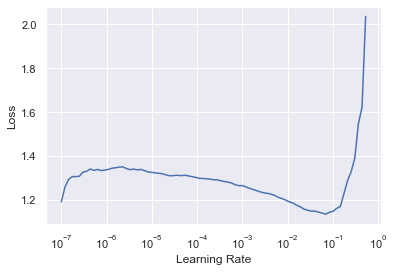

In [10]:
learn.lr_find()

Better model found at epoch 0 with matthews_corrcoef value: 0.6232562589309956.


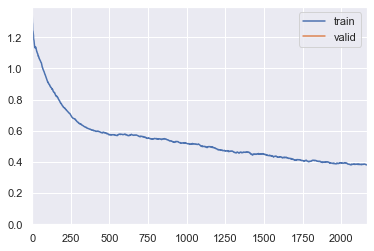

Better model found at epoch 0 with matthews_corrcoef value: 0.7754420241972589.


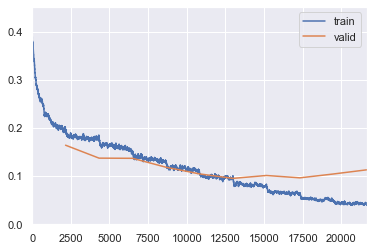

Better model found at epoch 1 with matthews_corrcoef value: 0.815328536942094.
Better model found at epoch 3 with matthews_corrcoef value: 0.835609058354621.
Better model found at epoch 4 with matthews_corrcoef value: 0.8539362983014827.
Better model found at epoch 5 with matthews_corrcoef value: 0.863624654653984.
Better model found at epoch 7 with matthews_corrcoef value: 0.8722399877154617.
Better model found at epoch 8 with matthews_corrcoef value: 0.8763575559706996.


In [11]:
learn.fine_tune(10,
                base_lr=1e-2, 
                cbs=[SaveModelCallback(monitor='matthews_corrcoef', comp=np.greater, fname='resnet18_best_mcc_fold_2'), # Salva o modelo de melhor mcc
                     EarlyStoppingCallback(monitor='matthews_corrcoef', comp=np.greater, min_delta=0.003, patience=2), # Para o treinamento caso o mcc não tenha melhorado no mínimo 0.003 em 2 épocas
                     ShowGraphCallback()]) # Mostra o gráfico do custo

### Interpretação

Criamos um interpretador para nossa CNN treinada.

In [17]:
path_to_results = "./Preds/preds_resnet18_fold_2.pt"
path_to_results = Path(path_to_results)
if path_to_results.exists():
    preds_data = torch.load(path_to_results)
else:
    preds_data = learn.get_preds(with_decoded=True, with_loss=True) # Obtemos as predições do modelo para o set de validação
    torch.save(preds_data, path_to_results) # Salvamos para uso posterior

preds_data_dict = {"inputs": None, "preds": preds_data[0], "targs": preds_data[1], "decoded": preds_data[2], "losses": preds_data[3]}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_data_dict)

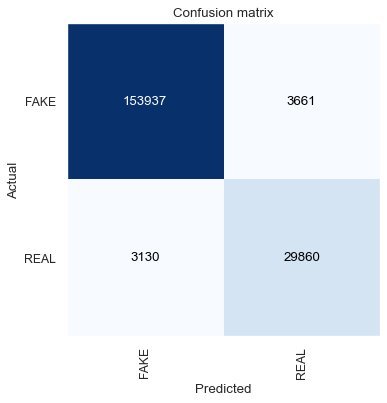

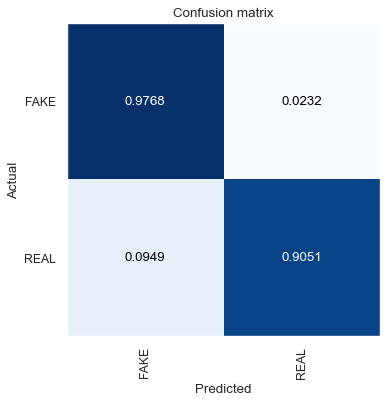

In [18]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

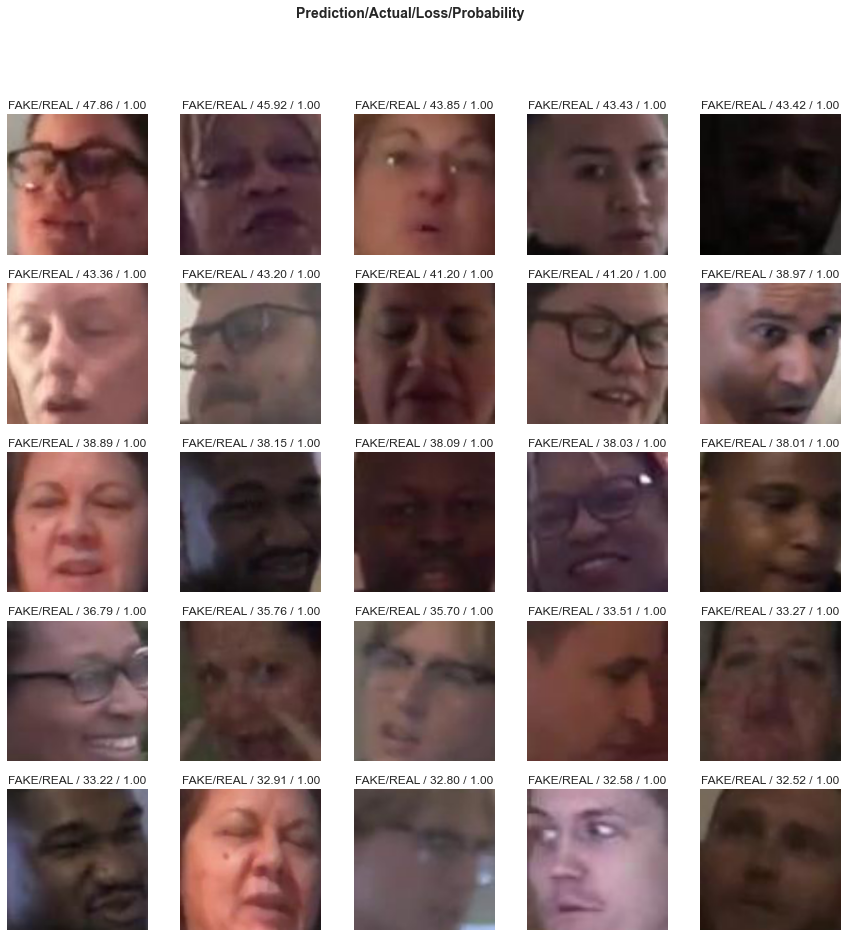

In [19]:
interp.plot_top_losses_without_input(learn=learn, k=25)

### Curva ROC e AUC

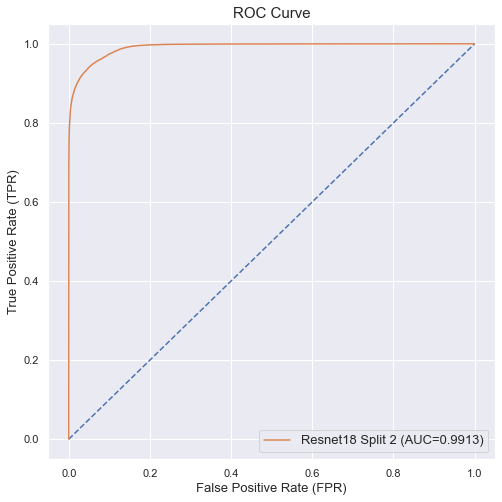

0.991334881469904

In [20]:
auc_score, _ = plot_ROC(preds=preds_data, labels=[f"Split {split+1}"], model_name='Resnet18')
auc_score

# Fold 3
## Treinamento

In [21]:
split = 2

# É necessário indicar `num_workers=0` se estiver em um sistema operacional Windows pois o Pytorch multiprocessing não funciona no Windows
fold_dataloader = data_cv[split].dataloaders(data_df, bs=BS, num_workers=0)

# Instaciamos uma nova rede vazia mas com o novo Fold como dados de entrada
learn = cnn_learner(dls=fold_dataloader, arch=resnet18, metrics=[accuracy, mcc, auroc]).to_fp16()

# Como dividimos o conjunto de dados de forma igualitária, não precisamos recalcular os pesos da função de custo
weight = torch.FloatTensor([1.0000, 2.7581]).to(device) # Temos de passar esse tensor para a placa de vídeo uma vez que o modelo está nela
learn.loss_func = CrossEntropyLossFlat(weight=weight)

print_dl_info(fold_dataloader)

DataLoader 3:
        Classes: ['FAKE', 'REAL']
        Quantidade de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 630,392 (82.69%)
        Quantidade de Classes REAL (treinamento): 131,960 (17.31%)
        Quantidade de classes FAKE (validação): 157,598 (82.69%)
        Quantidade de Classes REAL (validação): 32,990 (17.31%)
----------------------------------------------------------------------


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=7.585775847473997e-07)

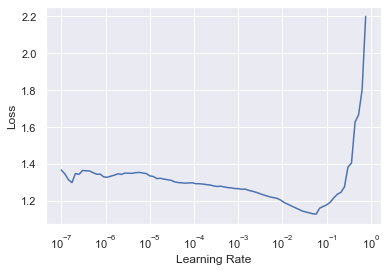

In [22]:
learn.lr_find()

Better model found at epoch 0 with matthews_corrcoef value: 0.6181686805156662.


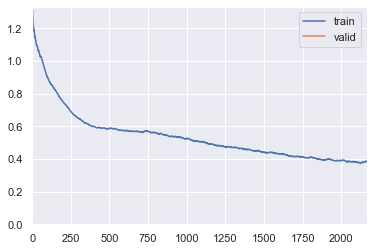

Better model found at epoch 0 with matthews_corrcoef value: 0.7870996221630469.


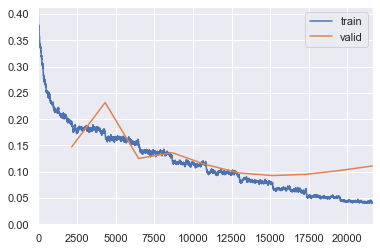

Better model found at epoch 2 with matthews_corrcoef value: 0.8160293402521481.
Better model found at epoch 4 with matthews_corrcoef value: 0.8398565619398023.
Better model found at epoch 5 with matthews_corrcoef value: 0.8617850129591854.
Better model found at epoch 6 with matthews_corrcoef value: 0.8648832653742421.
Better model found at epoch 7 with matthews_corrcoef value: 0.8717823024709855.
Better model found at epoch 8 with matthews_corrcoef value: 0.8757886033425081.
Better model found at epoch 9 with matthews_corrcoef value: 0.8765896668965436.


In [23]:
learn.fine_tune(10,
                base_lr=1e-2, 
                cbs=[SaveModelCallback(monitor='matthews_corrcoef', comp=np.greater, fname='resnet18_best_mcc_fold_3'), # Salva o modelo de melhor mcc
                     EarlyStoppingCallback(monitor='matthews_corrcoef', comp=np.greater, min_delta=0.003, patience=2), # Para o treinamento caso o mcc não tenha melhorado no mínimo 0.003 em 2 épocas
                     ShowGraphCallback()]) # Mostra o gráfico do custo


### Interpretação

Criamos um interpretador para nossa CNN treinada.

In [16]:
path_to_results = "./Preds/preds_resnet18_fold_3.pt"
path_to_results = Path(path_to_results)
if path_to_results.exists():
    preds_data = torch.load(path_to_results)
else:
    preds_data = learn.get_preds(with_decoded=True, with_loss=True) # Obtemos as predições do modelo para o set de validação
    torch.save(preds_data, path_to_results) # Salvamos para uso posterior

preds_data_dict = {"inputs": None, "preds": preds_data[0], "targs": preds_data[1], "decoded": preds_data[2], "losses": preds_data[3]}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_data_dict)

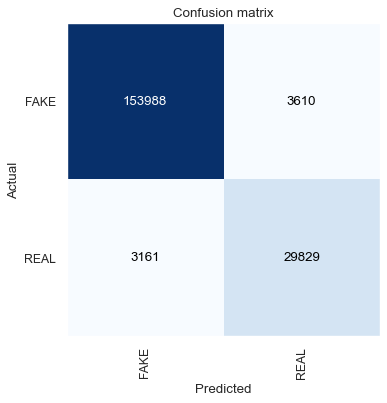

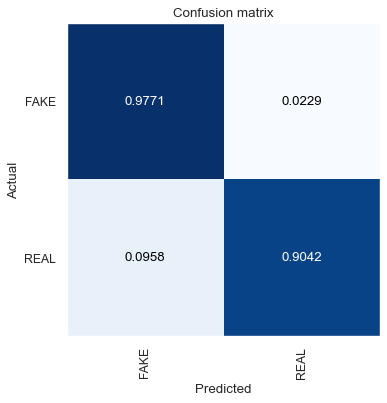

In [17]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

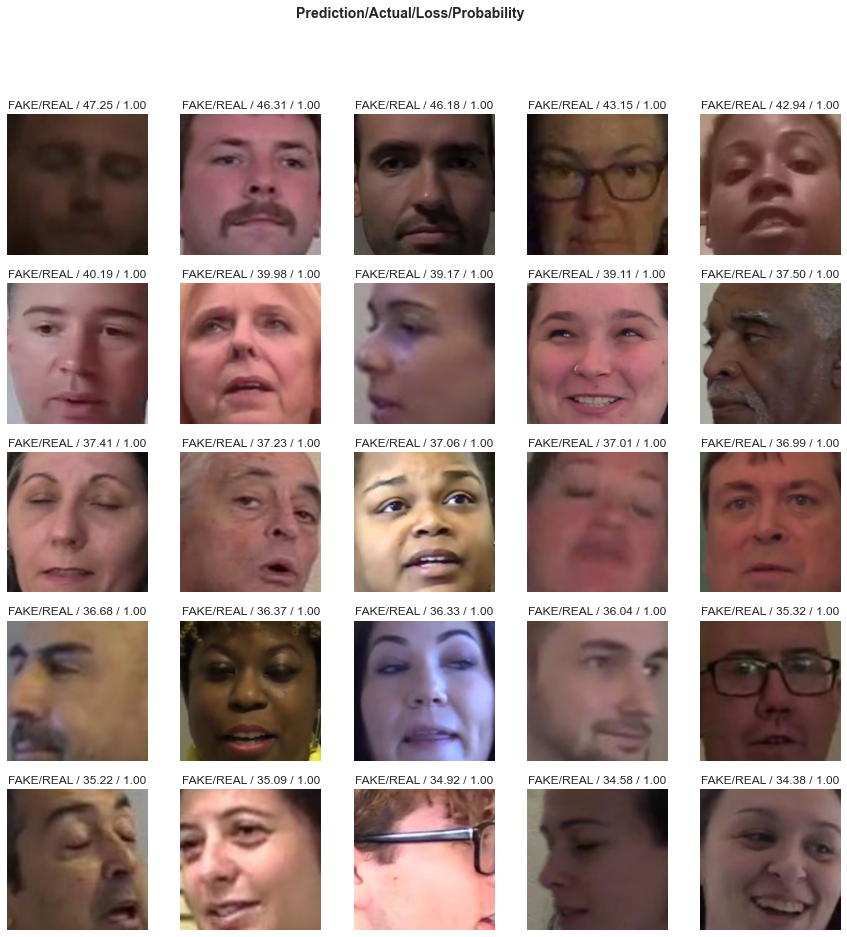

In [18]:
interp.plot_top_losses_without_input(learn=learn, k=25)

### Curva ROC e AUC

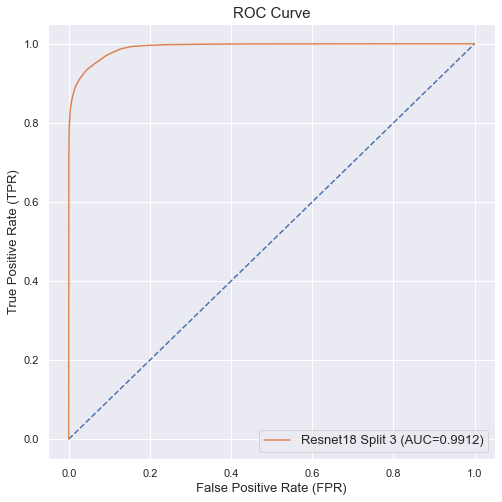

0.9911862835628913

In [26]:
auc_score, _ = plot_ROC(preds=preds_data, labels=[f"Split {split+1}"], model_name='Resnet18')
auc_score

# Fold 4
## Treinamento

In [12]:
split = 3

# É necessário indicar `num_workers=0` se estiver em um sistema operacional Windows pois o Pytorch multiprocessing não funciona no Windows
fold_dataloader = data_cv[split].dataloaders(data_df, bs=BS, num_workers=0)

# Instaciamos uma nova rede vazia mas com o novo Fold como dados de entrada
learn = cnn_learner(dls=fold_dataloader, arch=resnet18, metrics=[accuracy, mcc, auroc]).to_fp16()

# Como dividimos o conjunto de dados de forma igualitária, não precisamos recalcular os pesos da função de custo
weight = torch.FloatTensor([1.0000, 2.7581]).to(device) # Temos de passar esse tensor para a placa de vídeo uma vez que o modelo está nela
learn.loss_func = CrossEntropyLossFlat(weight=weight)

print_dl_info(fold_dataloader)

DataLoader 4:
        Classes: ['FAKE', 'REAL']
        Quantidade de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 630,392 (82.69%)
        Quantidade de Classes REAL (treinamento): 131,960 (17.31%)
        Quantidade de classes FAKE (validação): 157,598 (82.69%)
        Quantidade de Classes REAL (validação): 32,990 (17.31%)
----------------------------------------------------------------------


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.019054606556892395)

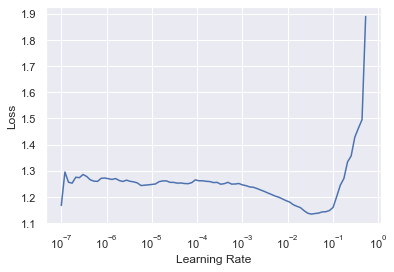

In [14]:
learn.lr_find()

Better model found at epoch 0 with matthews_corrcoef value: 0.618855344831957.


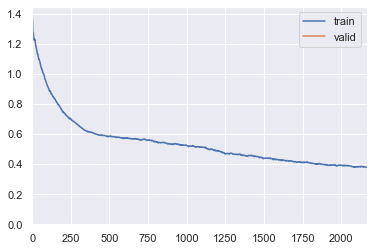

Better model found at epoch 0 with matthews_corrcoef value: 0.7913542515112569.


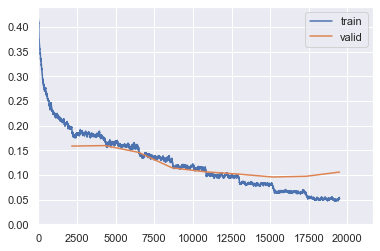

Better model found at epoch 2 with matthews_corrcoef value: 0.8099359968458094.
Better model found at epoch 3 with matthews_corrcoef value: 0.8404202670912934.
Better model found at epoch 4 with matthews_corrcoef value: 0.8469848075776131.
Better model found at epoch 5 with matthews_corrcoef value: 0.8563593106043276.
Better model found at epoch 6 with matthews_corrcoef value: 0.8704154130388204.
Better model found at epoch 7 with matthews_corrcoef value: 0.8775596603431078.
No improvement since epoch 7: early stopping


In [13]:
learn.fine_tune(10,
                base_lr=1e-2, 
                cbs=[SaveModelCallback(monitor='matthews_corrcoef', comp=np.greater, fname='resnet18_best_mcc_fold_4'), # Salva o modelo de melhor mcc
                     EarlyStoppingCallback(monitor='matthews_corrcoef', comp=np.greater, min_delta=0.003, patience=2), # Para o treinamento caso o mcc não tenha melhorado no mínimo 0.003 em 2 épocas
                     ShowGraphCallback()]) # Mostra o gráfico do custo


### Interpretação

Criamos um interpretador para nossa CNN treinada.

In [19]:
path_to_results = "./Preds/preds_resnet18_fold_4.pt"
path_to_results = Path(path_to_results)
if path_to_results.exists():
    preds_data = torch.load(path_to_results)
else:
    preds_data = learn.get_preds(with_decoded=True, with_loss=True) # Obtemos as predições do modelo para o set de validação
    torch.save(preds_data, path_to_results) # Salvamos para uso posterior

preds_data_dict = {"inputs": None, "preds": preds_data[0], "targs": preds_data[1], "decoded": preds_data[2], "losses": preds_data[3]}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_data_dict)

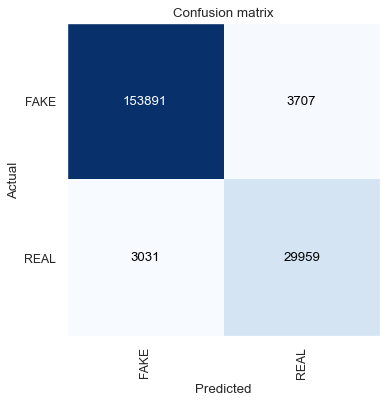

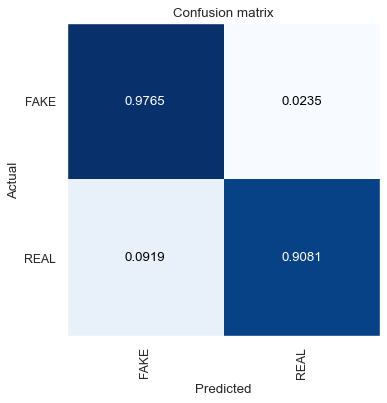

In [20]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

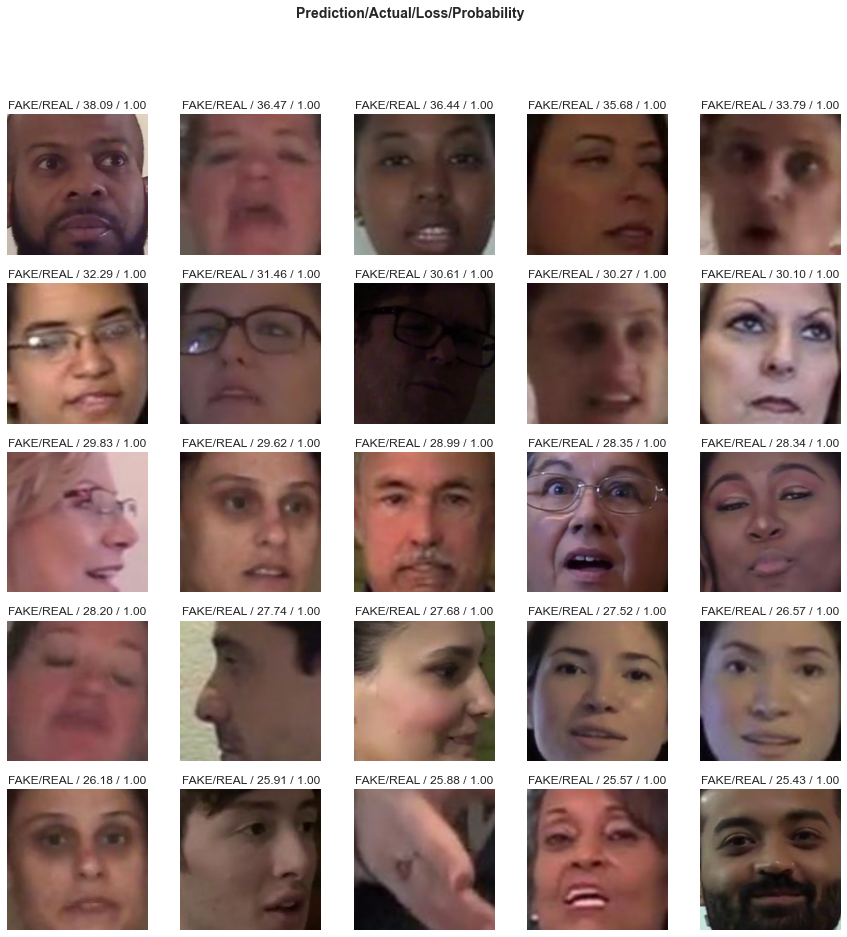

In [21]:
interp.plot_top_losses_without_input(learn=learn, k=25)

### Curva ROC e AUC

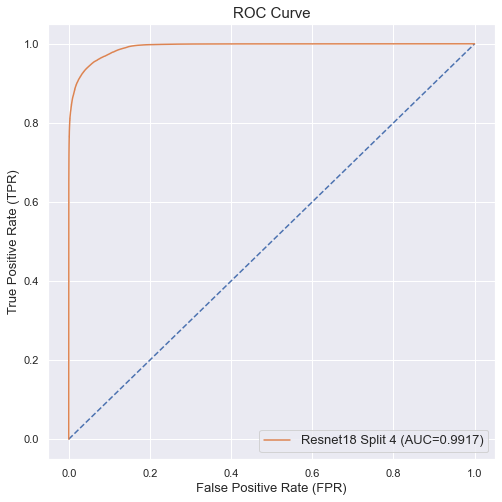

0.991650733573972

In [17]:
auc_score, _ = plot_ROC(preds=preds_data, labels=[f"Split {split+1}"], model_name='Resnet18')
auc_score

# Fold 5
## Treinamento

In [11]:
split = 4

# É necessário indicar `num_workers=0` se estiver em um sistema operacional Windows pois o Pytorch multiprocessing não funciona no Windows
fold_dataloader = data_cv[split].dataloaders(data_df, bs=BS, num_workers=0)

# Instaciamos uma nova rede vazia mas com o novo Fold como dados de entrada
learn = cnn_learner(dls=fold_dataloader, arch=resnet18, metrics=[accuracy, mcc, auroc]).to_fp16()

# Como dividimos o conjunto de dados de forma igualitária, não precisamos recalcular os pesos da função de custo
weight = torch.FloatTensor([1.0000, 2.7581]).to(device) # Temos de passar esse tensor para a placa de vídeo uma vez que o modelo está nela
learn.loss_func = CrossEntropyLossFlat(weight=weight)

print_dl_info(fold_dataloader)

DataLoader 5:
        Classes: ['FAKE', 'REAL']
        Quantidade de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 630,392 (82.69%)
        Quantidade de Classes REAL (treinamento): 131,960 (17.31%)
        Quantidade de classes FAKE (validação): 157,598 (82.69%)
        Quantidade de Classes REAL (validação): 32,990 (17.31%)
----------------------------------------------------------------------


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=1.9054607491852948e-06)

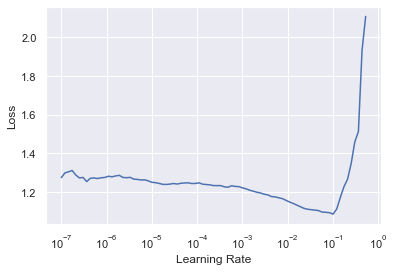

In [19]:
learn.lr_find()

Better model found at epoch 0 with matthews_corrcoef value: 0.5980492544982019.


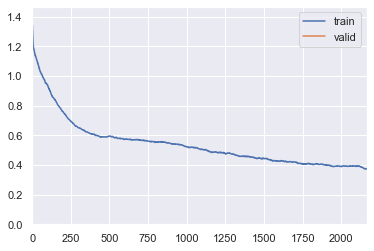

Better model found at epoch 0 with matthews_corrcoef value: 0.7832136918822512.


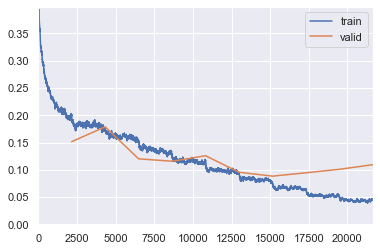

Better model found at epoch 2 with matthews_corrcoef value: 0.8274475342468308.
Better model found at epoch 3 with matthews_corrcoef value: 0.8354187598622488.
Better model found at epoch 5 with matthews_corrcoef value: 0.8693692217374868.
Better model found at epoch 6 with matthews_corrcoef value: 0.8768068325755505.
Better model found at epoch 7 with matthews_corrcoef value: 0.87729326445668.
Better model found at epoch 8 with matthews_corrcoef value: 0.8800144551536717.


In [12]:
learn.fine_tune(10,
                base_lr=1e-2, 
                cbs=[SaveModelCallback(monitor='matthews_corrcoef', comp=np.greater, fname='resnet18_best_mcc_fold_5'), # Salva o modelo de melhor mcc
                     EarlyStoppingCallback(monitor='matthews_corrcoef', comp=np.greater, min_delta=0.003, patience=2), # Para o treinamento caso o mcc não tenha melhorado no mínimo 0.003 em 2 épocas
                     ShowGraphCallback()]) # Mostra o gráfico do custo


### Interpretação

Criamos um interpretador para nossa CNN treinada.

In [18]:
path_to_results = "./Preds/preds_resnet18_fold_5.pt"
path_to_results = Path(path_to_results)
if path_to_results.exists():
    preds_data = torch.load(path_to_results)
else:
    preds_data = learn.get_preds(with_decoded=True, with_loss=True) # Obtemos as predições do modelo para o set de validação
    torch.save(preds_data, path_to_results) # Salvamos para uso posterior

preds_data_dict = {"inputs": None, "preds": preds_data[0], "targs": preds_data[1], "decoded": preds_data[2], "losses": preds_data[3]}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_data_dict)

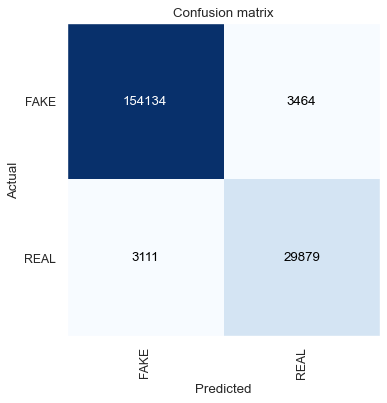

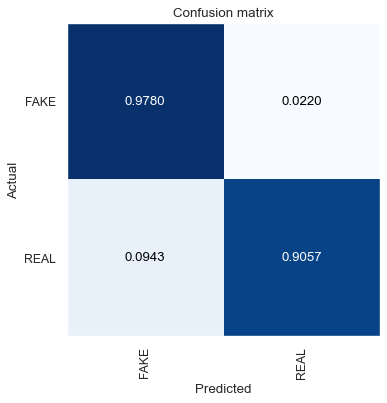

In [15]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

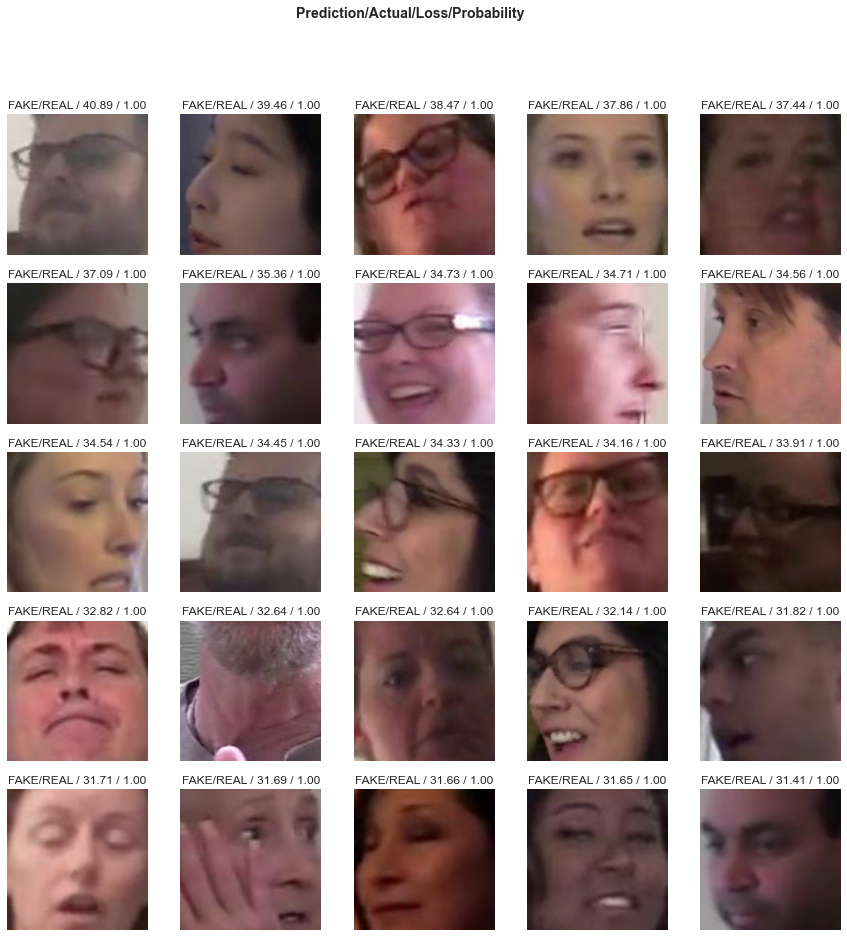

In [19]:
interp.plot_top_losses_without_input(learn=learn, k=25)

### Curva ROC e AUC

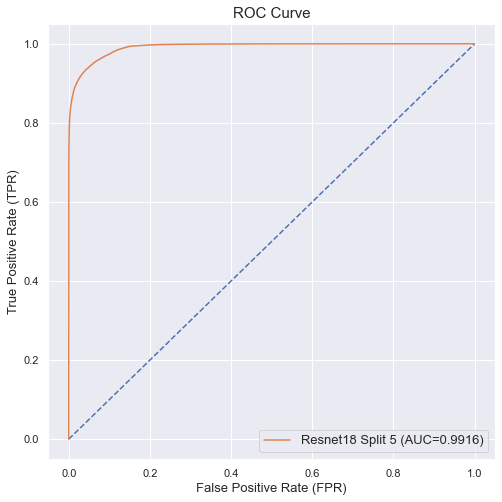

0.9916373543883938

In [20]:
auc_score, _ = plot_ROC(preds=preds_data, labels=[f"Split {split+1}"], model_name='Resnet18')
auc_score

# Treinamento Final

In [8]:
# Instaciamos uma nova rede vazia mas agora com o Dataset completo como entrada
learn = cnn_learner(dls=all_data,
                    arch=resnet18, 
                    metrics=[accuracy, mcc, auroc]
                   ).to_fp16()

weight = torch.FloatTensor([1.0000, 2.7581]).to(device) # Temos de passar esse tensor para a placa de vídeo uma vez que o modelo está nela
learn.loss_func = CrossEntropyLossFlat(weight=weight)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=9.12010818865383e-07)

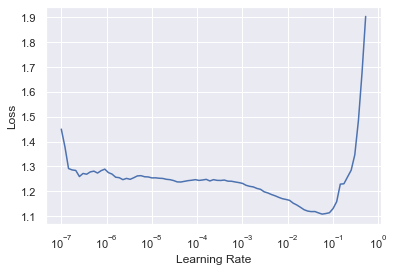

In [31]:
learn.lr_find()

Better model found at epoch 0 with matthews_corrcoef value: 0.6195242695164843.


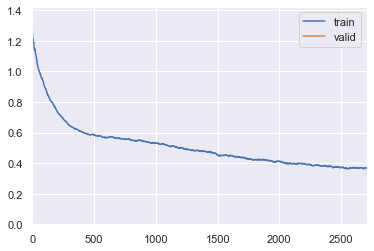

Better model found at epoch 0 with matthews_corrcoef value: 0.7678162026924191.


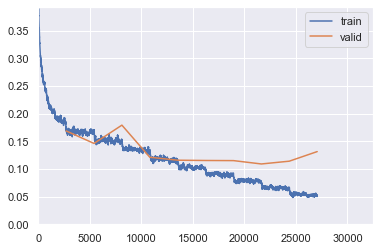

Better model found at epoch 1 with matthews_corrcoef value: 0.78731666755654.
Better model found at epoch 3 with matthews_corrcoef value: 0.8303832449113355.
Better model found at epoch 4 with matthews_corrcoef value: 0.8365921583670158.
Better model found at epoch 6 with matthews_corrcoef value: 0.8426778868464095.
Better model found at epoch 7 with matthews_corrcoef value: 0.8559155556981736.
Better model found at epoch 10 with matthews_corrcoef value: 0.8565894507267037.
No improvement since epoch 7: early stopping


In [32]:
learn.fine_tune(12,
                base_lr=1e-2, 
                cbs=[SaveModelCallback(monitor='matthews_corrcoef', comp=np.greater, fname='resnet18_best_mcc_F'), # Salva o modelo de melhor mcc
                     EarlyStoppingCallback(monitor='matthews_corrcoef', comp=np.greater, min_delta=0.003, patience=3), # Para o treinamento caso o mcc não tenha melhorado no mínimo 0.003 em 2 épocas
                     ShowGraphCallback()]) # Mostra o gráfico do custo


### Interpretação

Criamos um interpretador para nossa CNN treinada.

In [11]:
path_to_results = "./Preds/preds_resnet18_fold_F.pt"
path_to_results = Path(path_to_results)
if path_to_results.exists():
    preds_data = torch.load(path_to_results)
else:
    preds_data = learn.get_preds(with_decoded=True, with_loss=True) # Obtemos as predições do modelo para o set de validação
    torch.save(preds_data, path_to_results) # Salvamos para uso posterior

preds_data_dict = {"inputs": None, "preds": preds_data[0], "targs": preds_data[1], "decoded": preds_data[2], "losses": preds_data[3]}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_data_dict)

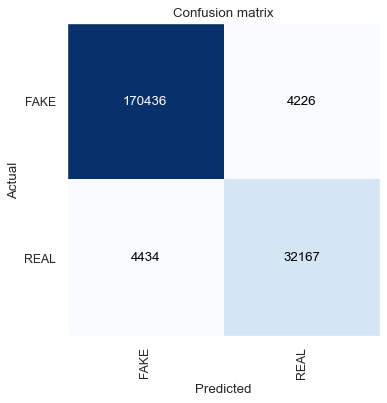

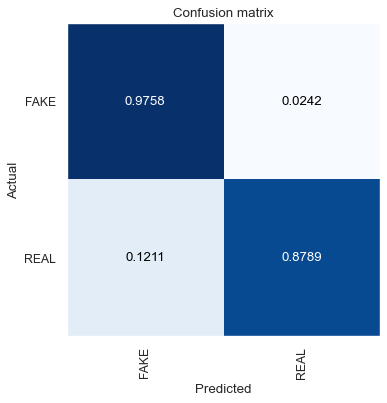

In [34]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

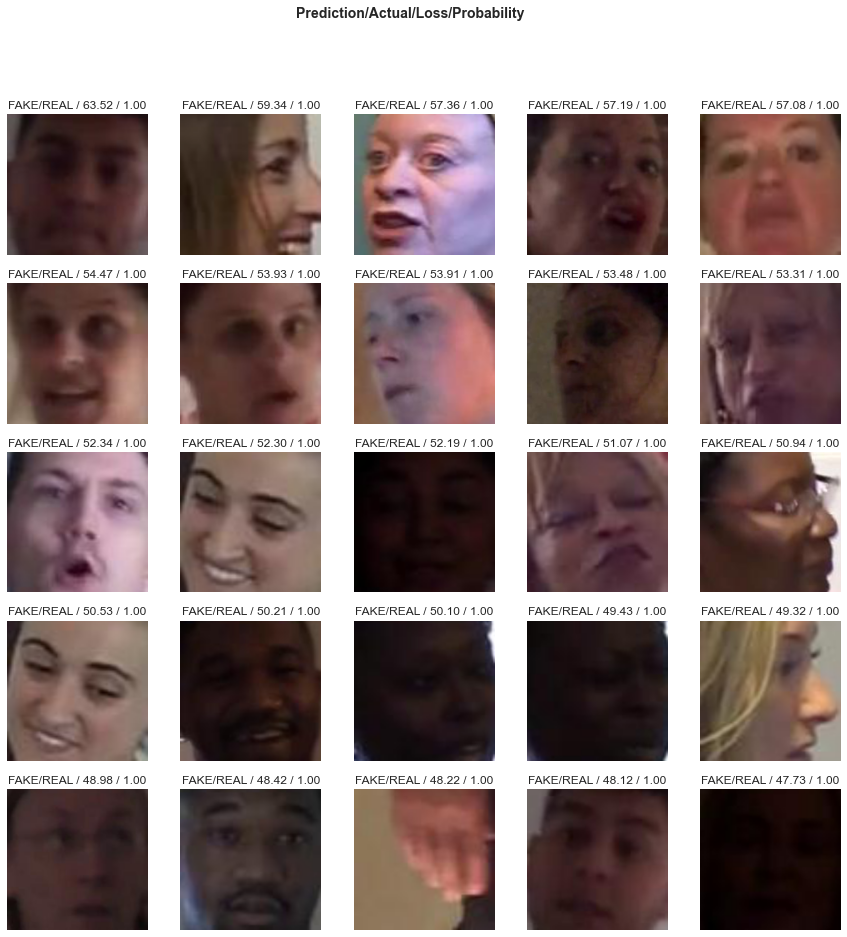

In [35]:
interp.plot_top_losses_without_input(learn=learn, k=25)

### Curva ROC e AUC

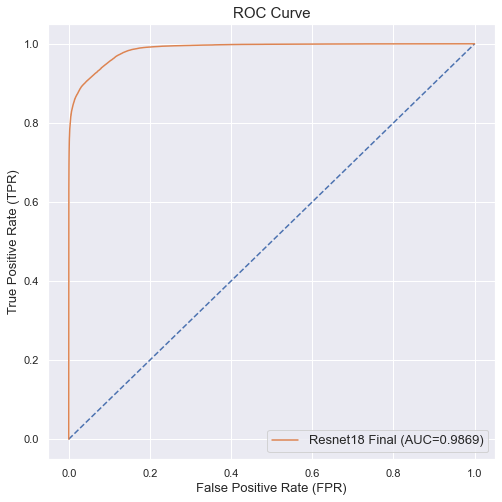

0.9868694637264002

In [36]:
auc_score, _ = plot_ROC(preds=preds_data, labels=[f"Final"], model_name='Resnet18')
auc_score

Podemos agora salvar o modelo serializado para uso em outras ocasiões.

In [ ]:
learn.export("final_learner.pkl")

# Avaliação Final por vídeo

A avaliação final foi resultado da inferência da rede nas faces individuais presentes no conjunto de dados. Agora, essas faces serão agrupadas por nome do vídeo. A predição final será dada pela contagem de faces preditas falsas e faces preditas reais por vídeo. Se a quantidade de faces preditas `FAKE` for maior ou igual a um valor $\rho$ vezes a quantidade de faces preditas `REAL`, o vídeo recebe a predição de `FAKE`, caso contrário, `REAL`.

Primeiro criamos o `DataFrame` utilizando o dicionário de predições obtido anteriormente para a etapa de interpretação.

In [16]:
preds_df = pd.DataFrame({"name": all_data.valid_ds.items, "prediction": preds_data_dict['decoded'], "target": preds_data_dict['targs']})
preds_df['name'] = preds_df['name'].apply(lambda x: x.stem.split()[1])
preds_df

name  prediction  target
0       aaqaifqrwn.mp4           0       0
1       aaqaifqrwn.mp4           0       0
2       aaqaifqrwn.mp4           0       0
3       aaqaifqrwn.mp4           0       0
4       aaqaifqrwn.mp4           0       0
...                ...         ...     ...
211258  zhvpwcvfcx.mp4           1       1
211259  zhvpwcvfcx.mp4           1       1
211260  zhvpwcvfcx.mp4           1       1
211261  zhvpwcvfcx.mp4           1       1
211262  zhvpwcvfcx.mp4           0       1

[211263 rows x 3 columns]

Em seguida definimos a função que recebe uma série contendo as predições para um vídeo e retorna a lógica de julgamento final.

In [17]:
def return_overall_prediction(roh=1.0):
    def _return_overall_prediction(series):
        qtd_fakes = np.count_nonzero(series == 0)
        qtd_reals = np.count_nonzero(series == 1)
        return 0 if qtd_fakes >= roh*qtd_reals else 1
    return _return_overall_prediction

Por fim, cria-se o `DataFrame` agrupado por nome e com a coluna `prediction` sendo sintetizada em um único valor de saída de predição por vídeo. A coluna `target` só necessita receber o primeiro valor uma vez que vai ser constante por vídeo.

In [18]:
preds_pervideo_df = preds_df.groupby(['name']).agg({'prediction': return_overall_prediction(roh=1.0), 'target': 'first'})
preds_pervideo_df

prediction  target
name                              
aaavflklag.mp4           0       0
aabdnomlru.mp4           0       0
aabunyewgi.mp4           0       0
aacfuwiwjw.mp4           1       1
aacweweyzz.mp4           0       0
...                    ...     ...
zzssjgskys.mp4           1       1
zzuyvxemjp.mp4           0       0
zzvtesaaml.mp4           0       0
zzycdovfhk.mp4           0       0
zzyyjpyuln.mp4           0       0

[17606 rows x 2 columns]

Agora, plotamos a matriz de confusão resultante final.

In [19]:
preds_pervideo_data_dict = {"inputs": None, "preds": None, "targs": torch.tensor(preds_pervideo_df['target']), "decoded": torch.tensor(preds_pervideo_df['prediction']), "losses": None}
interp = ClassificationInterpretation(dl=learn.dls[1], **preds_pervideo_data_dict)

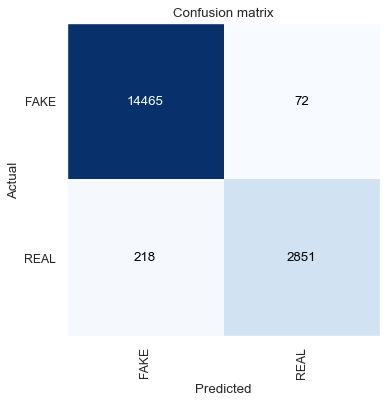

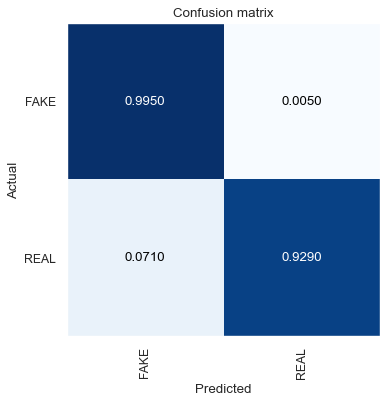

In [20]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

## Variando o valor de $\rho$

Variando agora o valor para $\rho$, podemos ver o comportamento da taxa de verdadeiros positivos e a taxa de verdadeiro negativos.

In [21]:
far = []
frr = []

range_for_rho = np.arange(0.25, 4.25, 0.25)
for rho in tqdm(range_for_rho):
    preds_pervideo_df = preds_df.groupby(['name']).agg({'prediction': return_overall_prediction(roh=rho), 'target': 'first'})
    preds_pervideo_data_dict = {"inputs": None, "preds": None, "targs": torch.tensor(preds_pervideo_df['target']), "decoded": torch.tensor(preds_pervideo_df['prediction']), "losses": None}

    interp = ClassificationInterpretation(dl=learn.dls[1], **preds_pervideo_data_dict)
    cm = interp.confusion_matrix()

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    far.append(cm_normalized[1,0])
    frr.append(cm_normalized[0,1])

  0%|          | 0/16 [00:00<?, ?it/s]

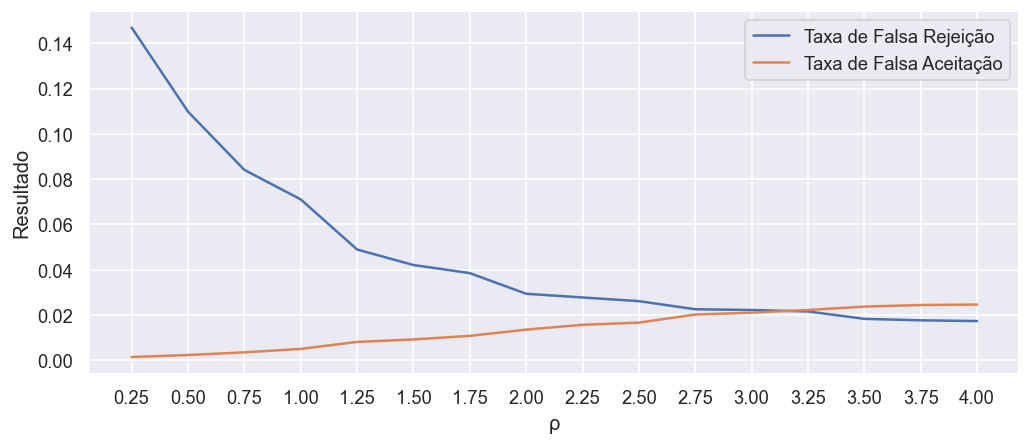

In [23]:
plt.figure(dpi=120, figsize=(10, 4))
sns.lineplot(x=range_for_rho, y=far)
sns.lineplot(x=range_for_rho, y=frr)

plt.xlabel("ρ")
plt.ylabel("Resultado")
plt.xticks(range_for_rho)
plt.legend(["Taxa de Falsa Rejeição", "Taxa de Falsa Aceitação"])
plt.show()

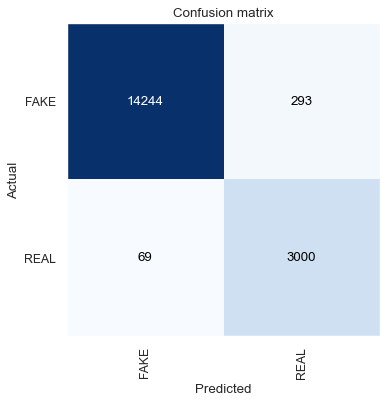

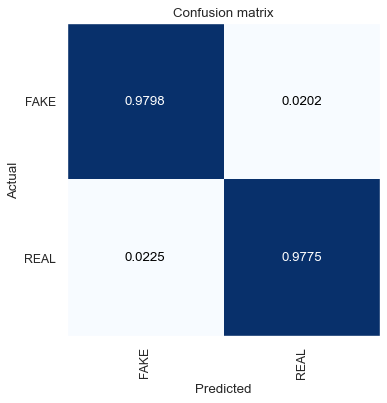

In [25]:
preds_pervideo_df = preds_df.groupby(['name']).agg({'prediction': return_overall_prediction(roh=2.75), 'target': 'first'})
preds_pervideo_data_dict = {"inputs": None, "preds": None, "targs": torch.tensor(preds_pervideo_df['target']), "decoded": torch.tensor(preds_pervideo_df['prediction']), "losses": None}

interp = ClassificationInterpretation(dl=learn.dls[1], **preds_pervideo_data_dict)
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=80)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=80)

## Distribuição de Probabilidades

Realizamos agora uma plotagem da densidade de probabilidades do modelo utilizando uma estimativa de densidade por kernel.

In [327]:
fakes_probs = preds_data_dict['preds'][preds_data_dict['targs'] == 0][:, 0]
reals_probs = preds_data_dict['preds'][preds_data_dict['targs'] == 1][:, 1]

In [328]:
fakes_probs = pd.DataFrame({"fakes_probs": fakes_probs, "Legenda": fakes_probs >= 0.5})
fakes_probs['Legenda'] = fakes_probs['Legenda'].apply(lambda x: "Correto" if x else "Incorreto")
fakes_probs

fakes_probs  Legenda
0               1.0  Correto
1               1.0  Correto
2               1.0  Correto
3               1.0  Correto
4               1.0  Correto
...             ...      ...
174657          1.0  Correto
174658          1.0  Correto
174659          1.0  Correto
174660          1.0  Correto
174661          1.0  Correto

[174662 rows x 2 columns]

In [329]:
reals_probs = pd.DataFrame({"reals_probs": reals_probs, "Legenda": reals_probs >= 0.5})
reals_probs['Legenda'] = reals_probs['Legenda'].apply(lambda x: "Correto" if x else "Incorreto")
reals_probs

reals_probs    Legenda
0         0.413063  Incorreto
1         0.000003  Incorreto
2         0.000001  Incorreto
3         0.000004  Incorreto
4         0.000014  Incorreto
...            ...        ...
36596     0.526160    Correto
36597     0.703702    Correto
36598     1.000000    Correto
36599     0.553339    Correto
36600     0.285621  Incorreto

[36601 rows x 2 columns]

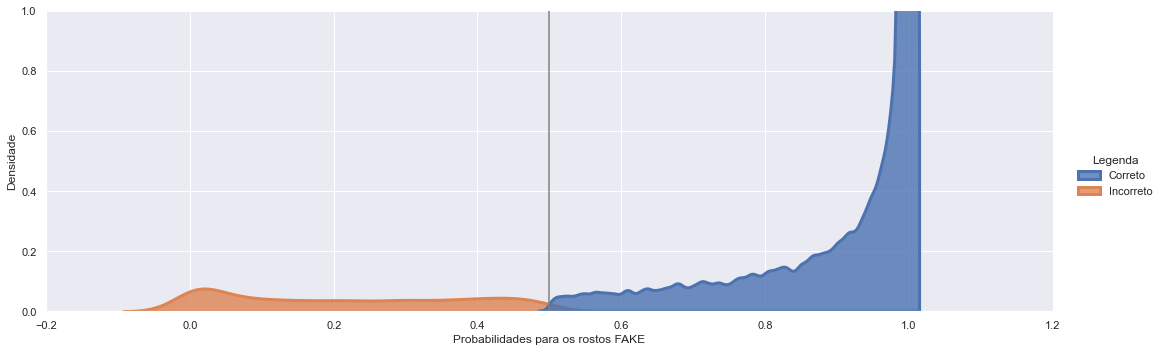

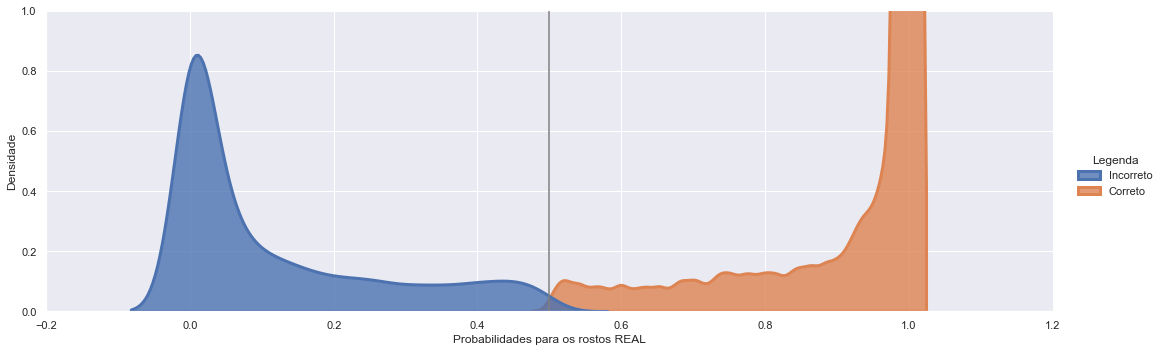

In [348]:
g = sns.displot(data=fakes_probs, x="fakes_probs", hue="Legenda", kind="kde", height=5, aspect=3, linewidth=3, fill=True, alpha=0.8)
g.axes[0][0].vlines(0.5, 0, 1, color="grey")
g.set_axis_labels("Probabilidades para os rostos FAKE", "Densidade")
plt.xlim(-0.2, 1.2)
plt.ylim(0, 1)

g = sns.displot(data=reals_probs, x="reals_probs", hue="Legenda", kind="kde", height=5, aspect=3, linewidth=3, fill=True, alpha=0.8)
g.axes[0][0].vlines(0.5, 0, 1, color="grey")
g.set_axis_labels("Probabilidades para os rostos REAL", "Densidade")
plt.xlim(-0.2, 1.2)
plt.ylim(0, 1)

plt.show()